## WHEN APPROACH

In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("List available databases and tables").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

spark.catalog.listDatabases()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-02-25 22:37:54,850 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-02-25 22:37:55,970 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2024-02-25 22:37:57,829 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental f

[Database(name='2023_11_01', description='FactSet data snapshot for 2023_11_01', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_01'),
 Database(name='2023_11_02', description='FactSet data snapshot for 2023_11_02', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_02'),
 Database(name='2023_11_03', description='FactSet data snapshot for 2023_11_03', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_03'),
 Database(name='2023_11_14', description='FactSet data snapshot for 2023_11_14', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_14'),
 Database(name='2023_11_19', description='FactSet data snapshot for 2023_11_19', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_19'),
 Database(name='2023_11_22', description='FactSet data snapshot for 2023_11_22', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_22'),
 Database(name='2024_01_25', description='FactSet da

In [2]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as F

spark.sql("USE 2023_11_02")


DataFrame[]

In [3]:
import os

curr_dir = os.getcwd()
main_dir = os.path.dirname(curr_dir)
print(main_dir)

/home/ztewari/Stock-Implosion-Prediction-FYP


In [4]:
from CreateDataset import get_tabular_dataset, get_feature_col_names, get_not_null_cols, get_tabular_dataset_qf
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv
from sklearn.impute import SimpleImputer

def plot_nulls(df):
    null_counts = df.agg(*[
    (1 - (F.count(c) / F.count('*'))).alias(c + '_nulls') for c in df.columns])
    null_counts_pd = null_counts.toPandas().transpose()
    null_counts_pd.columns = ['null_percentage']

    # Plot the bar chart
    null_counts_pd.plot(kind='bar', legend=False, figsize=(20, 6))
    plt.title('Percentage of Null Values in Each Column')
    plt.ylabel('Percentage of Null Values')
    plt.xlabel('Columns')
    plt.show()
    
def plot_nulls_per_year(df):
    # Extract year from the date_column
    df = df.withColumn('Year', F.year('date'))
    
    # Group by year and sum null values for each column
    nulls_per_year = df.groupBy('Year').agg(*[
        (1 - (F.count(c) / F.count('*'))).alias(c + '_nulls') for c in df.columns
    ]).toPandas()

    # Plot
    nulls_per_year.plot(kind='bar', x='Year', figsize=(20, 6))
    plt.title('Total Null Values per Year')
    plt.ylabel('Total Null Values')
    plt.xlabel('Year')
    plt.show()



def get_df(fn, all_feats=False, imploded_only=False, prediction=False):
    df = get_tabular_dataset(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.25)
    # df = get_tabular_dataset(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.2)

    
    return df



df = get_df(f'{main_dir}/data/imploded_stocks_price.csv', all_feats=True, imploded_only=False, prediction=False)
# df2 = get_tabular_dataset_qf(f'{main_dir}/data/imploded_stocks_price.csv', all_feats=True, imploded_only=False, prediction=False)

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-02-25 22:38:24,659 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


['ff_accr_exp', 'ff_assets_com_eq', 'ff_assets_eq', 'ff_assets_gr', 'ff_assets_oth_tot', 'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets', 'ff_capex_ps_cf', 'ff_cash_curr_assets', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr', 'ff_cf_sales', 'ff_cogs_sales', 'ff_com_eq_gr', 'ff_com_eq_tcap', 'ff_debt_com_eq', 'ff_debt_entrpr_val', 'ff_debt_eq', 'ff_debt_lt_cf', 'ff_debt_st_x_curr_port', 'ff_dfd_tax_assets_lt', 'ff_dil_adj', 'ff_div_yld', 'ff_div_yld_secs', 'ff_earn_yld', 'ff_ebit_oper_mgn', 'ff_ebit_oper_roa', 'ff_ebitda_oper_mgn', 'ff_eff_int_rate', 'ff_emp_gr', 'ff_entrpr_val_sales', 'ff_eps_basic_gr', 'ff_fix_assets_com_eq', 'ff_for_assets_pct', 'ff_for_sales_pct', 'ff_free_ps_cf', 'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund', 'ff_inc_tax_curr', 'ff_inc_tax_dfd', 'ff_int_exp_oth', 'ff_intang_oth', 'ff_invest_cap', 'ff_invest_lt', 'ff_invest_st_tot', 'ff_ltd_com_eq', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_mkt_val_gr', 'ff_mkt_val_public', 'ff_net_cf_debt', 'ff_net_inc_basic_af

In [5]:
df = df.toPandas()
df.head()

/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,...,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_fcf_yld,ff_compr_inc,ff_compr_inc_tot,GDP,Unemployment_Rate,CPI,label
0,B00FG1-R,2012-12-31,4.682,1.248053,1.248053,NaN,0.000,NaN,NaN,78.273974,...,0.000000,NaN,0.0,NaN,NaN,NaN,0.006181,7.9,-0.000121,0
1,B00FG1-R,2013-12-31,0.499,1.016917,1.016917,27.333701,0.000,NaN,56.273777,38.851847,...,0.000000,-32.489870,0.0,NaN,NaN,NaN,0.014049,6.7,0.002644,0
2,B00FG1-R,2014-12-31,NaN,NaN,-3.274929,1213.345113,2.152,NaN,-492.849757,11.984993,...,0.294125,3.610653,0.0,-95.4447,NaN,NaN,0.006058,5.6,-0.003085,0
3,B00FG1-R,2015-12-31,NaN,NaN,-2.277646,7.348883,0.000,NaN,-48.051855,0.483800,...,1.071870,19.546902,0.0,-11.9743,NaN,NaN,0.001821,5.0,-0.001076,0
4,B00FG1-R,2016-12-31,NaN,NaN,-22.304275,76.903869,0.000,NaN,85.114102,2.179701,...,0.710952,21.835781,0.0,-22.8867,NaN,NaN,0.010414,4.7,0.002525,0


In [6]:
# df=df.toPandas()
print(len(df[df['label']==1]))

667


In [7]:
df[df['fsym_id']=='B0CXCV-R'].sort_values(by=['fsym_id', 'date']).head(20)

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,...,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_fcf_yld,ff_compr_inc,ff_compr_inc_tot,GDP,Unemployment_Rate,CPI,label
152,B0CXCV-R,2015-12-31,0.892413,NaN,-0.402277,NaN,0.083579,NaN,NaN,4.249913,...,0.0,NaN,0.000,NaN,-9.097105,-9.109441,0.001821,5.0,-0.001076,0
153,B0CXCV-R,2016-12-31,2.091352,NaN,-0.117528,-12.032382,0.097546,NaN,-2631.288095,0.000000,...,0.0,NaN,0.000,NaN,-9.708269,-9.709015,0.010414,4.7,0.002525,0
154,B0CXCV-R,2017-12-31,0.715220,NaN,-0.048958,54.556835,0.097546,0.042850,-29.878111,11.395396,...,0.0,NaN,0.000,NaN,-25.652213,-25.656703,0.017494,4.1,0.002107,0
155,B0CXCV-R,2018-12-31,0.660945,1.415922,1.415922,271.038353,0.093578,0.120127,NaN,1.605581,...,0.0,NaN,0.000,-43.4143,-67.356411,-67.359557,0.005728,3.9,0.000685,0
156,B0CXCV-R,2019-12-31,0.695000,7.107744,3.800180,-21.897343,0.106000,0.093822,-90.388042,0.828991,...,0.0,-447.654602,0.000,-95.6397,-12.038000,-12.041000,0.009593,3.6,0.003154,0
157,B0CXCV-R,2020-12-31,1.060000,1.544423,1.427903,167.621980,0.041000,0.297342,82.302726,0.460218,...,0.0,-202.630768,0.039,-53.4781,-12.705000,-12.705000,0.017409,6.7,0.004685,1


In [8]:
def convert_to_prediction(df):
    df_temp = spark.createDataFrame(df)
    ws = Window.partitionBy('fsym_id').orderBy(F.col('date').desc())
    df_temp = df_temp.withColumn('label', F.lag(F.col('label')).over(ws))
    df_temp= df_temp.filter(F.col('label').isNotNull())
    return df_temp.toPandas()

df = convert_to_prediction(df)

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-02-25 22:40:12,824 WARN scheduler.TaskSetManager: Stage 22 contains a task of very large size (9076 KiB). The maximum recommended task size is 1000 KiB.
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-

In [9]:
df[df['fsym_id']=='B0CXCV-R'].sort_values(by=['fsym_id', 'date']).head(20)

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,...,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_fcf_yld,ff_compr_inc,ff_compr_inc_tot,GDP,Unemployment_Rate,CPI,label
58119,B0CXCV-R,2015-12-31,0.892413,NaN,-0.402277,NaN,0.083579,NaN,NaN,4.249913,...,0.0,NaN,0.0,NaN,-9.097105,-9.109441,0.001821,5.0,-0.001076,0
58118,B0CXCV-R,2016-12-31,2.091352,NaN,-0.117528,-12.032382,0.097546,NaN,-2631.288095,0.000000,...,0.0,NaN,0.0,NaN,-9.708269,-9.709015,0.010414,4.7,0.002525,0
58117,B0CXCV-R,2017-12-31,0.715220,NaN,-0.048958,54.556835,0.097546,0.042850,-29.878111,11.395396,...,0.0,NaN,0.0,NaN,-25.652213,-25.656703,0.017494,4.1,0.002107,0
58116,B0CXCV-R,2018-12-31,0.660945,1.415922,1.415922,271.038353,0.093578,0.120127,NaN,1.605581,...,0.0,NaN,0.0,-43.4143,-67.356411,-67.359557,0.005728,3.9,0.000685,0
58115,B0CXCV-R,2019-12-31,0.695000,7.107744,3.800180,-21.897343,0.106000,0.093822,-90.388042,0.828991,...,0.0,-447.654602,0.0,-95.6397,-12.038000,-12.041000,0.009593,3.6,0.003154,1


In [10]:
# groups = df.groupby('fsym_id')
# for fsym_id, group_data in groups:
#     if group_data['label'].sum() == 1:
#         print(f"fsym_id: {fsym_id}")
#         print(group_data[['fsym_id', 'date', 'label', 'label2']])

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def correlation_matrix(df):
    # df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr().abs()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.savefig('corr_matrix_when.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    corr_dict = {}
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.8:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                if corr_mat.columns[i] not in corr_dict.keys():
                    corr_dict[corr_mat.columns[i]] = [corr_mat.columns[j]]
                else:
                    corr_dict[corr_mat.columns[i]].append(corr_mat.columns[j])
                    
    for k,v in corr_dict.items():
        if len(corr_dict[k]) >= 1:
            for col in corr_dict[k]:
                if col in df.columns:
                    df=df.drop(col,axis=1)
    
                

    print(df.columns)
    return df

    
               
df=correlation_matrix(df)

Converted to Pandas
Variable pairs with absolute correlation above 0.7:
ff_accr_exp - ff_assets_gr: 0.9978385343031658
ff_accr_exp - ff_com_eq_gr: 0.9978558813093102
ff_accr_exp - ff_debt_lt_cf: 0.9971510902327728
ff_accr_exp - ff_debt_st_x_curr_port: 0.9937294697182635
ff_accr_exp - ff_inc_tax_curr: 0.9943972056549445
ff_accr_exp - ff_inc_tax_dfd: 0.9730018774740575
ff_accr_exp - ff_int_exp_oth: 0.9980721553257696
ff_accr_exp - ff_invest_cap: 0.9988464603873759
ff_accr_exp - ff_invest_lt: 0.9210570427248246
ff_accr_exp - ff_net_inc_basic_aft_xord: 0.9950343667548887
ff_accr_exp - ff_net_inc_basic_beft_xord: 0.9951369133558915
ff_accr_exp - ff_net_inc_bef_xord_gr: 0.9979050694809406
ff_accr_exp - ff_oper_inc_aft_unusual: 0.9818839586324738
ff_accr_exp - ff_oper_inc_gr: 0.9978730171794736
ff_accr_exp - ff_sales_gr: 0.9978410277895103
ff_accr_exp - ff_sales_ps_gr: 0.9978584236561349
ff_accr_exp - ff_sga_oth: 0.999252573135207
ff_accr_exp - ff_ut_gross_inc: 0.9890683671525907
ff_accr_exp 

In [12]:
# print(len(df[df['label']==1]))

In [13]:
df.columns

Index(['fsym_id', 'date', 'ff_accr_exp', 'ff_assets_com_eq',
       'ff_assets_oth_tot', 'ff_assets_per_emp', 'ff_bps_gr',
       'ff_capex_assets', 'ff_cash_curr_assets', 'ff_cash_div_cf',
       'ff_cash_roce', 'ff_cf_ps_gr', 'ff_cf_sales', 'ff_com_eq_tcap',
       'ff_debt_entrpr_val', 'ff_dfd_tax_assets_lt', 'ff_dil_adj',
       'ff_div_yld', 'ff_earn_yld', 'ff_ebit_oper_roa', 'ff_eff_int_rate',
       'ff_emp_gr', 'ff_entrpr_val_sales', 'ff_eps_basic_gr',
       'ff_fix_assets_com_eq', 'ff_for_assets_pct', 'ff_for_sales_pct',
       'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund', 'ff_intang_oth',
       'ff_invest_st_tot', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_mkt_val_gr',
       'ff_mkt_val_public', 'ff_net_inc_per_emp', 'ff_net_mgn_gr',
       'ff_non_oper_exp', 'ff_oper_cf_fix_chrg', 'ff_oper_inc_tcap',
       'ff_oper_ps_net_cf', 'ff_pfd_stk_tcap', 'ff_receiv_curr_assets',
       'ff_receiv_turn', 'ff_reinvest_rate', 'ff_roic', 'ff_shs_float',
       'ff_tcap_assets', 'ff_xor

In [14]:

feats = df.columns[2:-1]


In [15]:

# Assuming df is your DataFrame
null_values_per_column = df.isnull().sum()
total_rows = len(df)

print("Proportion of null values per column:")
for column, null_count in null_values_per_column.items():
    proportion_null = null_count / total_rows
    print(f"Column '{column}': {proportion_null:.2%}")


Proportion of null values per column:
Column 'fsym_id': 0.00%
Column 'date': 0.00%
Column 'ff_accr_exp': 25.87%
Column 'ff_assets_com_eq': 8.87%
Column 'ff_assets_oth_tot': 5.81%
Column 'ff_assets_per_emp': 16.30%
Column 'ff_bps_gr': 11.82%
Column 'ff_capex_assets': 2.87%
Column 'ff_cash_curr_assets': 25.87%
Column 'ff_cash_div_cf': 2.47%
Column 'ff_cash_roce': 14.20%
Column 'ff_cf_ps_gr': 17.19%
Column 'ff_cf_sales': 7.48%
Column 'ff_com_eq_tcap': 3.60%
Column 'ff_debt_entrpr_val': 15.68%
Column 'ff_dfd_tax_assets_lt': 0.00%
Column 'ff_dil_adj': 0.90%
Column 'ff_div_yld': 15.99%
Column 'ff_earn_yld': 15.84%
Column 'ff_ebit_oper_roa': 20.83%
Column 'ff_eff_int_rate': 21.95%
Column 'ff_emp_gr': 22.30%
Column 'ff_entrpr_val_sales': 19.17%
Column 'ff_eps_basic_gr': 19.27%
Column 'ff_fix_assets_com_eq': 10.33%
Column 'ff_for_assets_pct': 18.45%
Column 'ff_for_sales_pct': 11.69%
Column 'ff_gross_cf_debt': 17.94%
Column 'ff_inc_adj': 0.07%
Column 'ff_inc_sund': 0.05%
Column 'ff_intang_oth': 

In [16]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(df.drop(['fsym_id', 'label', 'date' ], axis=1))
mask = selector.get_support()
remaining_feats = df.drop(['fsym_id', 'label', 'date'], axis=1).columns[mask]
print(remaining_feats)

Index(['ff_accr_exp', 'ff_assets_com_eq', 'ff_assets_oth_tot',
       'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets',
       'ff_cash_curr_assets', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr',
       'ff_cf_sales', 'ff_com_eq_tcap', 'ff_debt_entrpr_val',
       'ff_dfd_tax_assets_lt', 'ff_dil_adj', 'ff_div_yld', 'ff_earn_yld',
       'ff_ebit_oper_roa', 'ff_eff_int_rate', 'ff_emp_gr',
       'ff_entrpr_val_sales', 'ff_eps_basic_gr', 'ff_fix_assets_com_eq',
       'ff_for_assets_pct', 'ff_for_sales_pct', 'ff_gross_cf_debt',
       'ff_inc_adj', 'ff_inc_sund', 'ff_intang_oth', 'ff_invest_st_tot',
       'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_mkt_val_gr', 'ff_mkt_val_public',
       'ff_net_inc_per_emp', 'ff_net_mgn_gr', 'ff_non_oper_exp',
       'ff_oper_cf_fix_chrg', 'ff_oper_inc_tcap', 'ff_oper_ps_net_cf',
       'ff_pfd_stk_tcap', 'ff_receiv_curr_assets', 'ff_receiv_turn',
       'ff_reinvest_rate', 'ff_roic', 'ff_shs_float', 'ff_tcap_assets',
       'ff_xord', 'ff_xord_disc',

In [17]:
df = df[remaining_feats.tolist()+['fsym_id', 'label', 'date']]

In [18]:
rows_with_null_count = df.isnull().any(axis=1).sum()

print(rows_with_null_count)

86289


In [19]:
print(len(df))

103643


In [20]:
split_date = '2020-01-01'
df=df.reset_index()
df['date'] = pd.to_datetime(df['date'])
train_df = df[df['date'] < split_date]
test_df = df[df['date'] >= split_date]

In [21]:
%%capture
import warnings
warnings.filterwarnings("ignore")
import tsfel

# train_df = train_df.reset_index()
# test_df = test_df.reset_index()
feats = train_df.drop(['fsym_id', 'label', 'date'], axis=1).columns.tolist()
print(len(train_df))
test_df[feats] = test_df.groupby('fsym_id')[feats].transform(lambda x : x.fillna(method='ffill'))
test_df[feats] = test_df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year'] = test_df['date'].dt.year
test_df[feats] = test_df.groupby(['year'])[feats].fillna(test_df.median())

train_df[feats] = train_df.groupby('fsym_id')[feats].transform(lambda x : x.fillna(method='ffill'))
train_df[feats] = train_df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['year'] = train_df['date'].dt.year


print(len(test_df))
print(len(train_df))


In [22]:
print(len(test_df))
print(len(train_df))

12799
90844


In [23]:
mask = (train_df['label'] == 0) & (train_df.isnull().any(axis=1))

train_df = train_df[~mask]

In [24]:
null_rows = test_df[test_df.isnull().any(axis=1)]

# Print out the rows with null values
print(null_rows)

Empty DataFrame
Columns: [index, ff_accr_exp, ff_assets_com_eq, ff_assets_oth_tot, ff_assets_per_emp, ff_bps_gr, ff_capex_assets, ff_cash_curr_assets, ff_cash_div_cf, ff_cash_roce, ff_cf_ps_gr, ff_cf_sales, ff_com_eq_tcap, ff_debt_entrpr_val, ff_dfd_tax_assets_lt, ff_dil_adj, ff_div_yld, ff_earn_yld, ff_ebit_oper_roa, ff_eff_int_rate, ff_emp_gr, ff_entrpr_val_sales, ff_eps_basic_gr, ff_fix_assets_com_eq, ff_for_assets_pct, ff_for_sales_pct, ff_gross_cf_debt, ff_inc_adj, ff_inc_sund, ff_intang_oth, ff_invest_st_tot, ff_ltd_tcap, ff_min_int_tcap, ff_mkt_val_gr, ff_mkt_val_public, ff_net_inc_per_emp, ff_net_mgn_gr, ff_non_oper_exp, ff_oper_cf_fix_chrg, ff_oper_inc_tcap, ff_oper_ps_net_cf, ff_pfd_stk_tcap, ff_receiv_curr_assets, ff_receiv_turn, ff_reinvest_rate, ff_roic, ff_shs_float, ff_tcap_assets, ff_xord, ff_xord_disc, ff_eps_dil_aft_xord, ff_std_debt, ff_tang_assets_debt, ff_bk_oper_inc_oth, ff_bk_non_oper_inc, ff_commiss_inc_net, ff_cf_roic, ff_liabs_lease, ff_compr_inc, Unemployment

In [25]:
null_rows = train_df[train_df.isnull().any(axis=1)]

# Print out the rows with null values
print(null_rows)

         index  ff_accr_exp  ff_assets_com_eq  ff_assets_oth_tot  \
19          19    70.152000          1.744019                NaN   
1417      1417     0.000000          1.960773           0.021728   
1622      1622          NaN         18.473399          31.849000   
1895      1895    32.609000          1.736805           2.078000   
1950      1950     4.876000          2.434970           0.543000   
...        ...          ...               ...                ...   
102192  102192     0.106566          1.284065           0.442392   
102329  102329     4.518000          1.489404           0.112000   
102833  102833     5.370000          1.443828           1.518000   
103333  103333     0.000000          9.914593           0.000000   
103609  103609     2.755000          2.498863           0.000000   

        ff_assets_per_emp   ff_bps_gr  ff_capex_assets  ff_cash_curr_assets  \
19               0.595847  -27.838054         5.640216            77.549887   
1417             0.075731

In [26]:
train_df[feats] = train_df.groupby(['year'])[feats].transform(lambda x: x.fillna(x.loc[train_df['label'] == 1].median()))

In [27]:
# df[df['fsym_id']=='B0CXCV-R'].sort_values(by=['fsym_id', 'date']).head(20)

In [28]:
%%capture
import warnings
warnings.filterwarnings("ignore")
import tsfel

def feature_extraction_tsfel(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df = df.set_index('date')

    print("retrieving features...")
    cfg = tsfel.get_features_by_domain(domain="statistical", json_path='features3.json')
    print("features retrieved")
    
    result_dfs = []
    for fsym_id, group_df in df.groupby(['fsym_id', 'year']):
        # Exclude 'fsym_id' column from group_df

        X = tsfel.time_series_features_extractor(cfg, group_df.drop(['fsym_id', 'year'], axis=1), verbose=0)
        X['fsym_id'] = group_df['fsym_id'].iloc[0]
        X['year'] = group_df['year'].iloc[0]
        print(X.head())
        result_dfs.append(X)
        # except ValueError:
        #     print("error caught")
        #     continue
    
    final_result = pd.concat(result_dfs, ignore_index=True)
    final_result.reset_index(drop=True, inplace=True)
    return final_result

# df3 = feature_extraction_tsfel(df2) #takes too long

In [32]:
exclude_columns = ['fsym_id', 'label']
feats = train_df.drop(exclude_columns, axis=1).columns.tolist()
print(feats)

['index', 'ff_accr_exp', 'ff_assets_com_eq', 'ff_assets_oth_tot', 'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets', 'ff_cash_curr_assets', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr', 'ff_cf_sales', 'ff_com_eq_tcap', 'ff_debt_entrpr_val', 'ff_dfd_tax_assets_lt', 'ff_dil_adj', 'ff_div_yld', 'ff_earn_yld', 'ff_ebit_oper_roa', 'ff_eff_int_rate', 'ff_emp_gr', 'ff_entrpr_val_sales', 'ff_eps_basic_gr', 'ff_fix_assets_com_eq', 'ff_for_assets_pct', 'ff_for_sales_pct', 'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund', 'ff_intang_oth', 'ff_invest_st_tot', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_mkt_val_gr', 'ff_mkt_val_public', 'ff_net_inc_per_emp', 'ff_net_mgn_gr', 'ff_non_oper_exp', 'ff_oper_cf_fix_chrg', 'ff_oper_inc_tcap', 'ff_oper_ps_net_cf', 'ff_pfd_stk_tcap', 'ff_receiv_curr_assets', 'ff_receiv_turn', 'ff_reinvest_rate', 'ff_roic', 'ff_shs_float', 'ff_tcap_assets', 'ff_xord', 'ff_xord_disc', 'ff_eps_dil_aft_xord', 'ff_std_debt', 'ff_tang_assets_debt', 'ff_bk_oper_inc_oth', 'ff_bk_non_

In [34]:
print(len(train_df.columns))
print(len(train_df['fsym_id']))
print(len(test_df['fsym_id']))
print(len(test_df[test_df['label']==1]))
print(len(train_df[train_df['label']==1]))

64
50089
12799
127
499


In [33]:
import os
import pandas as pd

train_file = 'train_df_when.csv'
test_file = 'test_df_when.csv'

# Check if the files exist
if not (os.path.exists(train_file) and os.path.exists(test_file)):
    # Write DataFrames to files
    train_df.to_csv(train_file, index=False)
    test_df.to_csv(test_file, index=False)
else:
    # Read DataFrames from existing files
    print("works")
    train_df = pd.read_csv(train_file, index_col=False)
    test_df = pd.read_csv(test_file, index_col=False)

works


In [35]:
train_df.head()

,index,ff_accr_exp,ff_assets_com_eq,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_curr_assets,ff_cash_div_cf,ff_cash_roce,...,ff_bk_non_oper_inc,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_compr_inc,Unemployment_Rate,fsym_id,label,date,year
2,2,19.539,1.177160,3.273,1.703338,46.218731,0.210647,88.138173,0.0,12.477873,...,0.000,0.000000,13.149844,12.455,115.553,3.6,BHZYXG-R,0,2019-12-31,2019
3,3,16.412,1.205895,3.439,1.230111,79.509394,7.637973,86.069026,0.0,18.571861,...,28.954,0.045552,14.742053,0.000,25.208,3.9,BHZYXG-R,0,2018-12-31,2018
4,4,38.969,1.563511,4.193,0.752473,-2.043736,0.810028,84.431610,0.0,-1.489816,...,-13.959,0.003600,-1.509609,0.000,-15.567,4.1,BHZYXG-R,0,2017-12-31,2017
5,5,45.765,1.601873,2.465,1.481507,-3.935307,0.668809,81.148270,0.0,2.273441,...,-17.241,0.003600,-6.130346,0.000,-18.010,4.7,BHZYXG-R,0,2016-12-31,2016
6,6,45.989,1.601555,3.181,1.805508,-19.847899,1.186107,85.969726,0.0,-11.700086,...,-39.545,0.003600,8.473203,0.000,-39.865,5.0,BHZYXG-R,0,2015-12-31,2015


Converted to Pandas
{0: 0.5050312563016737, 1: 50.18937875751503}
Estimate: 99.379
 25%|██▌       | 25/100 [00:32<01:37,  1.30s/trial, best loss: -0.243445821156355] 
Best params:{'colsample_bytree': 0.8500000000000001, 'eta': 0.875, 'gamma': 2.75, 'max_depth': 749.0, 'min_child_weight': 7.0, 'n_estimators': 341.0, 'subsample': 0.9500000000000001}


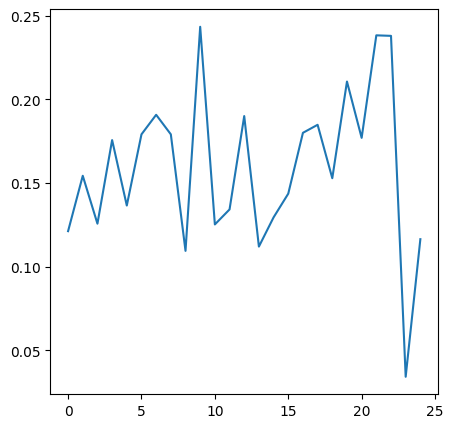

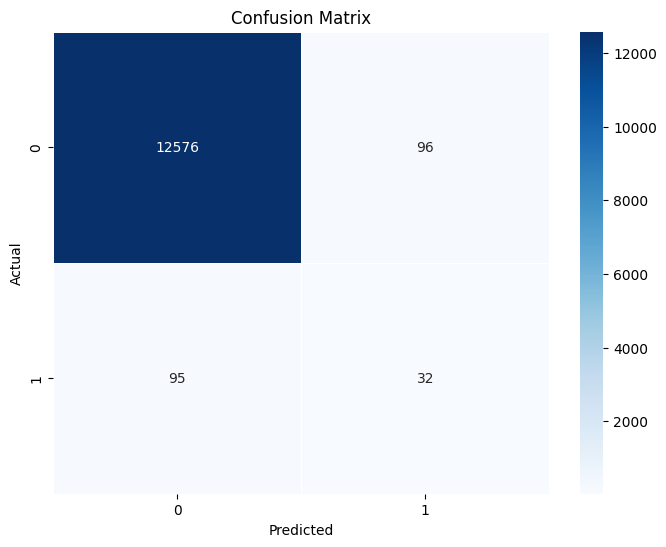

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp
from sklearn import tree
import shap
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from collections import Counter
from hyperopt.early_stop import no_progress_loss
from functools import reduce
# import lightgbm
import datetime
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef

current_date = datetime.datetime.now()
current_date= current_date.strftime("%Y-%m-%d") 

def feature_importances(model, features, model_name):
    feature_importances = model.feature_importances_

    # print("Feature Importances:")
    # for feature, importance in zip(features, feature_importances):
    #     print(f"{feature}: {importance}")

    sorted_idx = np.argsort(feature_importances)
    sorted_features = [features[i] for i in sorted_idx]
    
    half_len = (len(sorted_idx) // 4 ) * 3 # Calculate the index for the middle point

    # Select the lowest 50% of features
    selected_features = [features[i] for i in sorted_idx[:half_len]]

    plt.figure(figsize=(20, 6))
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
    plt.xticks(range(len(feature_importances)), sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importances")
    plt.savefig(f'results_when/{model_name}_feature_importances.png')
    return selected_features

def model_testing(train_df, test_df, classifier):
    seed = 42
    print("Converted to Pandas")
    # train_df = train_df.reset_index()
    # test_df = test_df.reset_index()
    exclude_columns = ['fsym_id', 'label', 'date']
    X_train = train_df.drop(exclude_columns, axis=1)
    y_train = train_df['label']
    X_test = test_df.drop(exclude_columns, axis=1)
    y_test = test_df['label']
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    if classifier == 'LogisticRegression':
        param_space = {
            'C': hp.uniform('C', 0.01, 1.0) }
        classifier_instance = LogisticRegression(class_weight = class_weight_dict, solver='sag', random_state=seed)
        scaler = StandardScaler()
        feats = X_train.columns
        X_train[feats] = scaler.fit_transform(X_train[feats])
        X_test[feats] = scaler.transform(X_test[feats])
        
    elif classifier == 'RandomForest':
        param_space = { 
            'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
            'max_depth': hp.quniform('max_depth', 5, 1200, 1),
            'max_features': hp.choice('max_features', [ 'sqrt','log2', None]),
            'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
            'min_samples_split' : hp.uniform ('min_samples_split', 0, 1)
        }
        classifier_instance = RandomForestClassifier(class_weight = class_weight_dict, random_state=seed)
    elif classifier == 'GBT':
        param_space = { 'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.quniform('max_depth',5,20,1),
           'min_samples_leaf':hp.quniform('min_samples_leaf',1,5,1),
           'min_samples_split':hp.quniform('min_samples_split',2,6,1)}
        classifier_instance = GradientBoostingClassifier()
    elif classifier == 'XGB':
        param_space = { 'n_estimators':hp.quniform('n_estimators',100,1000,1),
                        'max_depth':hp.quniform('max_depth',5,1200,1),
                       'eta': hp.quniform('eta', 0.025, 1, 0.025),
                       'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
                        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
                        'gamma': hp.quniform('gamma', 0.5, 5, 0.05),
                        'colsample_bytree': hp.quniform('colsample_bytree', 0, 1, 0.05)
                      }
        counter = Counter(y_train)
        # estimate scale_pos_weight value
        estimate = counter[0] / counter[1]
        print('Estimate: %.3f' % estimate)
        
        classifier_instance = xgb.XGBClassifier(scale_pos_weight=estimate, seed=seed)
    else:
        raise ValueError("Unsupported classifier")
        
    tscv = TimeSeriesSplit(n_splits=3)
    
    def set_params(classifier, params):
        if classifier == 'RandomForest':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'GBT':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            params['min_samples_leaf'] = int(params['min_samples_leaf'])
            params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'XGB':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        
        else:
            return params
    
    obj_scores = []
        
    def objective(params):
        params = set_params(classifier, params)
        classifier_instance.set_params(**params)
        classifier_instance.fit(X_train, y_train)
        # scores = cross_val_score(classifier_instance, X_train, y_train, cv=tscv, scoring='matthews_corrcoef')
        y_pred = classifier_instance.predict(X_test)
        # recall = recall_score(y_test, y_pred)
        score = matthews_corrcoef(y_test, y_pred)
        obj_scores.append(score)
        return -score

    def report_average(*args):
        report_list = list()
        for report in args:
            splited = [' '.join(x.split()) for x in report.split('\n\n')]
            header = [x for x in splited[0].split(' ')]
            data = np.array(splited[1].split(' ')).reshape(-1, len(header) + 1)
            data = np.delete(data, 0, 1).astype(float)
            rest = splited[2].split(' ')
            accuarcy =np.array([0, 0, rest[1], rest[2]]).astype(float).reshape(-1, len(header))
            macro_avg = np.array([rest[5:9]]).astype(float).reshape(-1, len(header))
            weighted_avg = np.array([rest[11:]]).astype(float).reshape(-1, len(header))
            #avg_total = np.array([x for x in avg]).astype(float).reshape(-1, len(header))
            df = pd.DataFrame(np.concatenate((data, accuarcy,macro_avg,weighted_avg)), columns=header)
            report_list.append(df)
        res = reduce(lambda x, y: x.add(y, fill_value=0), report_list) / len(report_list)
        # res.to_csv(f'when_{classifier}_results.csv')
        return res.rename(index={res.index[-3]: 'accuracy',res.index[-2]: 'macro_avg',res.index[-1]: 'weighted_avg'})
    
    
#     initial_model = classifier_instance
#     initial_model = initial_model.fit(X_train, y_train)
#     initial_preds = pd.DataFrame()
#     print("INITIAL: ")
#     initial_preds['prediction'] = initial_model.predict(X_test)
#     initial_preds['label'] = y_test
#     confusion_matrix_pandas(initial_preds)
    
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, early_stop_fn=no_progress_loss(15))
    print(f"Best params:{best_params}")
    best_params = set_params(classifier, best_params)
    classifier_instance.set_params(**best_params)
    i = 0
    all_reports = []
    plt.figure(figsize=(5,5))
    plt.plot(obj_scores)
    plt.show()
    
    classifier_instance.fit(X_train, y_train)
    preds = classifier_instance.predict(X_test)
    final_report = classification_report(y_test, preds)
    mcc = matthews_corrcoef(y_test, preds)
    filename = f'results_when/report_{classifier}_when'
    existing_mcc = None
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('MCC:'):
                    existing_mcc = float(line.split(':')[1])
                    break
    except FileNotFoundError:
        pass

    # Overwriting file only if new MCC is larger
    if existing_mcc is None or mcc > existing_mcc:
        with open(filename, 'w') as f:
            f.write(final_report)
            f.write('\nMCC: ' + str(mcc))
            f.write('\nHyperparams: ' + str(best_params))
    
#     for train_index, test_index in tscv.split(X_train):
#         x_train, x_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
#         Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
#         classifier_instance.fit(x_train, Y_train)
        
#         preds = classifier_instance.predict(x_test)
#         report = classification_report(Y_test, preds)
#         print(report)
#         all_reports.append(report)
    cm = confusion_matrix(y_test, preds, labels=classifier_instance.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    test_df['preds'] = preds

    return classifier_instance, X_train.columns.tolist(), X_train, X_test, test_df


model, feats, X_train, X_test, test_df_with_preds = model_testing(train_df, test_df, 'XGB')

['ff_xord_disc', 'ff_xord', 'ff_pfd_stk_tcap', 'ff_dil_adj', 'ff_inc_adj', 'ff_bk_oper_inc_oth', 'ff_assets_per_emp', 'ff_commiss_inc_net', 'ff_eps_basic_gr', 'ff_cf_ps_gr', 'Unemployment_Rate', 'ff_inc_sund', 'ff_non_oper_exp', 'ff_liabs_lease', 'ff_invest_st_tot', 'ff_tcap_assets', 'ff_com_eq_tcap', 'ff_for_sales_pct', 'ff_assets_com_eq', 'ff_debt_entrpr_val', 'ff_min_int_tcap', 'ff_capex_assets', 'ff_dfd_tax_assets_lt', 'ff_tang_assets_debt', 'ff_entrpr_val_sales', 'ff_invest_lt', 'ff_assets_gr', 'ff_ltd_tcap', 'ff_for_assets_pct', 'ff_fix_assets_com_eq', 'ff_std_debt', 'ff_ebit_oper_roa', 'ff_div_yld', 'ff_net_inc_per_emp', 'ff_cash_div_cf', 'ff_reinvest_rate']
Converted to Pandas
{0: 0.5039312387735165, 1: 64.09318637274549}
 23%|██▎       | 23/100 [05:08<17:14, 13.43s/trial, best loss: -0.1869535268261508]
Best params:{'max_depth': 677.0, 'max_features': 1, 'min_samples_leaf': 0.03423629921532456, 'min_samples_split': 0.040546716761385215, 'n_estimators': 318.0}


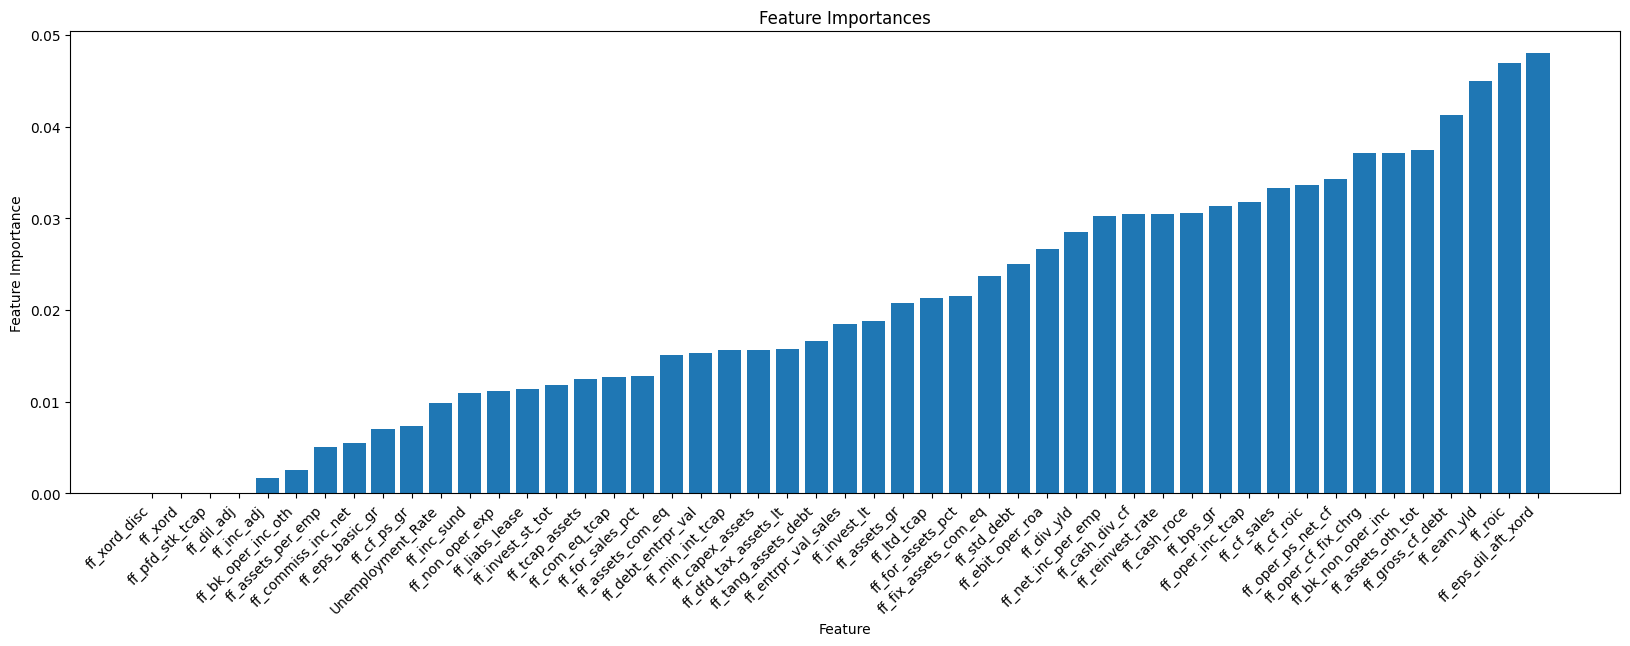

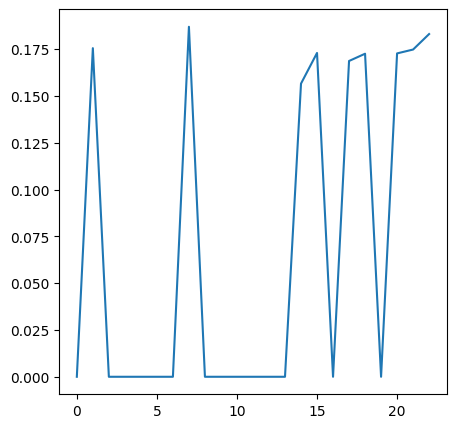

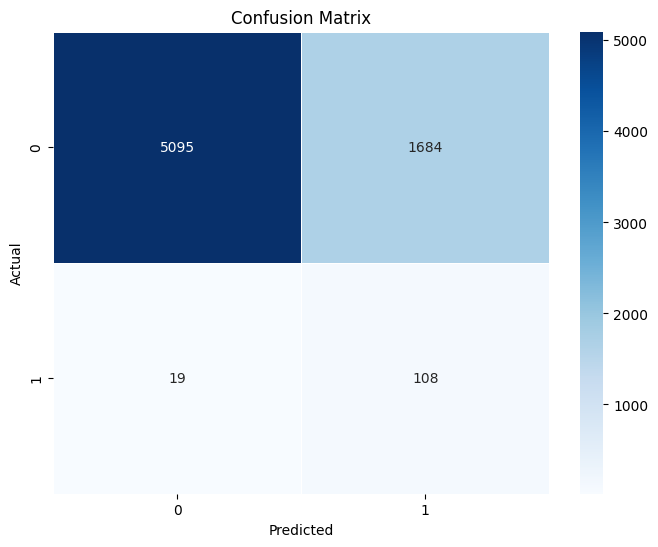

In [53]:
feats_to_drop = feature_importances(model,feats, 'RandomForest')
print(feats_to_drop)
train_df2 = train_df.drop(feats_to_drop, axis=1)
test_df2 = test_df.drop(feats_to_drop, axis=1)
model2, feats2, _,_,_ = model_testing(train_df2, test_df2, 'RandomForest')

In [34]:
_ = feature_importances(model2,feats2)

NameError: name 'model2' is not defined

In [66]:
len(X_train.columns)

64

In [59]:
def shapley(model, X_train, X_test, model_name):
    shap.initjs()
    # # X_train = X_train.drop(['fsym_id',  'label', 'date'], axis=1)
    # X_test = X_test.drop(['fsym_id',  'label', 'preds', 'date'], axis=1 )
    explainer = shap.Explainer(model, X_train) #Explainer, model.predict for log reg
    shap_values = explainer.shap_values(X_test)
    # print(shap_values.shape)
    # shap.summary_plot(shap_values, X_test, show=False)
    shap.plots.beeswarm(shap_values, show=False)
    plt.tight_layout()
    plt.savefig(f'results_when/shapley_{model_name}_beeswarm.png')
    # shap.plots.waterfall(shap_values[0])

shapley(model, X_train, X_test, 'RandomForest')

100%|===================| 13785/13812 [01:35<00:00]        

TypeError: The beeswarm plot requires an `Explanation` object as the `shap_values` argument.

In [45]:
train_df.head()

,index,fsym_id,ff_accr_exp,ff_assets_com_eq,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_capex_fix_assets,ff_cash_curr_assets,...,ff_std_debt,ff_bk_oper_inc_oth,ff_bk_non_oper_inc,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_compr_inc,GDP,Unemployment_Rate,label
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,48976,GJZ5YB-R,143.784000,1.729254,42.422,0.067783,40.774170,21.456759,38.323007,2.935040,...,16.327238,0.0,418.805,0.0,6.031711,47.160,258.142,0.011395,3.9,0
2000-01-31,87865,GSXP1N-R,6.019841,1.194269,0.000,0.184405,17.212545,2.732302,25.527204,70.773903,...,0.000000,0.0,0.000,0.0,-23.401890,0.000,14.350,0.011395,3.9,0
2000-01-31,70510,WPKF66-R,389.953000,2.733014,81.397,0.054461,4.659683,12.656485,33.016331,33.537477,...,51.517129,0.0,534.159,0.0,68.939663,0.018,570.000,0.011395,3.9,0
2000-01-31,89899,LWY6TY-R,6.947000,1.902163,1.656,0.276648,29.050884,6.648226,14.881759,14.276476,...,6.672323,0.0,0.000,0.0,5.554106,0.000,28.144,0.011395,3.9,0
2000-01-31,38583,BZNBHW-R,29.544000,2.373729,4.166,0.092724,-6.072055,5.046265,6.617032,3.564810,...,5.623622,0.0,0.000,0.0,7.655820,0.000,-7.665,0.011395,3.9,0


In [94]:
from sklearn.ensemble import IsolationForest

def anomaly_det(train_df, test_df):
    train_df = train_df.reset_index()
    test_df = test_df.reset_index()
    exclude_columns = ['fsym_id', 'label', 'date']
    features = train_df.drop(exclude_columns, axis=1).columns
    print("Converted to Pandas")
    train_df['date'] = pd.to_datetime(train_df['date'])
    train_df.set_index('date', inplace=True)
    train_df.sort_index(inplace=True)
    test_df['date'] = pd.to_datetime(test_df['date'])
    test_df.set_index('date', inplace=True)
    test_df.sort_index(inplace=True)
    contam = len(train_df[train_df['label']==1])/len(train_df)
    isol_for = IsolationForest(contamination=contam, random_state=42)
    non_anomalies = train_df[train_df['label']==0]
    isol_for.fit(non_anomalies[features])
    test_df['anomaly_scores'] = isol_for.decision_function(test_df[features])
    test_df['anomaly'] = isol_for.predict(test_df[features])
    test_df['preds'] = np.where(test_df['anomaly'] == 1, 0, 1)
    print(f"Classification Report: ")
    print(classification_report(test_df['label'], test_df['preds']))
    cm = confusion_matrix(test_df['label'], test_df['preds'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    
    
# anomaly_det(train_df, test_df)

{0: 0.5055204769127659, 1: 45.78594249201278}
52130 499 5194 127
0.009664736301834169
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1057 (4.13 KB)
Trainable params: 1057 (4.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
163/163 [==============================] - 0s 2ms/step - loss: 0.3566 - cross entropy: 0.3566 - Brier score: 0.0863 - tp: 92.0000 - fp: 561.0000 - tn: 4506.0000 - fn: 35.0000 - accuracy: 0.8853 -

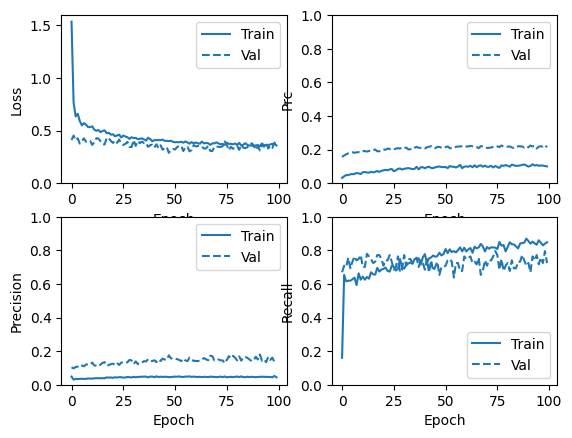

In [91]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

# Generate some dummy time series data


# Define the number of folds for cross-validation

def plot_model_performance(mdl, loss, metric):
    x = pd.DataFrame(mdl.history).reset_index()
    x = pd.melt(x, id_vars='index')
    x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
    x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})
    g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
    g.map(sns.lineplot, 'index','value')
    g.add_legend()
    return g

def plot_metrics(history):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':#
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        
    
def plot_loss(history, label, n):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

def nn_training(df):
    df=df.set_index('date')
    df=df.sort_index()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)

    seed = 42
    exclude_columns = ['fsym_id', 'label']
    X = df.drop(exclude_columns, axis=1)
    y = df['label']

    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'batch_size': hp.choice('batch_size', [16, 32, 64]),
    'num_layers': hp.choice('num_layers', [1, 2, 3]),
    'num_neurons': hp.choice('num_neurons', [64, 128, 256]),
    'activation': hp.choice('activation', ['relu', 'sigmoid']),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5)
    }
    
    METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    
    def make_model(train_features, metrics=METRICS, output_bias=None):
        if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)
            
        model = keras.Sequential([
              keras.layers.Dense(
                  16, activation='relu',
                  input_shape=(train_features.shape[-1],)),
              keras.layers.Dropout(0.5),
              keras.layers.Dense(1, activation='sigmoid',
                                 bias_initializer=output_bias),
          ])
   
        
        model.compile(
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=metrics)
        return model
    
    def get_preds(model, feats, truth):
        predictions = model.predict(feats, batch_size = 2048)
        print(predictions)
        for i in range(len(predictions)):
            predictions[i] = 1 if predictions[i] >= 0.5 else 0
        print(classification_report(truth, predictions))
    
    
    
#     model = tf.keras.Sequential([
#         tf.keras.layers.Flatten(input_shape=(X.shape[1],)),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(32, activation='relu'),  # Additional Dense layer
#         tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
#         tf.keras.layers.Dense(16, activation='relu'),  # Another Dense layer
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    split_date = '2020-01-01'
    train_index = X.index < split_date
    test_index = X.index >= split_date


    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    
    print(len(y_train), len(y_train[y_train==1]), len(y_test), len(y_test[y_test==1]))

    scaler=StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    

    pos = len(y_train[y_train==1])
    neg = len(y_train[y_train==0])
    print(pos/neg)
    initial_bias = np.log([pos/neg])

    model = make_model(X_train, output_bias=initial_bias)
    print(model.summary())

    fit_model = model.fit(X_train, y_train, epochs=100, batch_size=2048, validation_data = (X_test, y_test), class_weight = class_weight_dict, 
                        
                         verbose=0)
    # plot_model_performance(fit_model, 'bin_cross_entropy', 'accuracy')
    plot_metrics(fit_model)
    # plot_loss(fit_model, "Train Loss", 0)

    results = model.evaluate(X_test, y_test)
    print(f'Test loss: {results[0]}')

    # Make predictions on new data
    get_preds(model, X_train, y_train)
    get_preds(model, X_test, y_test)
        

#     cm = confusion_matrix(y_test, predictions)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
#     plt.title(f'Confusion Matrix')
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.show()


    
nn_training(df)

In [68]:
from hyperopt import hp, fmin, tpe, Trials
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import matthews_corrcoef, f1_score

# Define the search space for hyperparameters

def hyperopt_nn(train_df, test_df):
    train_df = train_df.set_index('date')
    train_df = train_df.sort_index()
    test_df = test_df.set_index('date')
    test_df = test_df.sort_index()
    
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
        'batch_size': hp.choice('batch_size', [1024, 2048, 4096]),
        'num_layers': hp.choice('num_layers', [2, 3, 4, 5, 6]),
        'num_neurons': hp.choice('num_neurons', [128, 256, 512, 1024, 2048, 4096]),
        'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
        'class_weight_0': hp.uniform('class_weight_0', 0.1, 5),  
        'class_weight_1': hp.uniform('class_weight_1', 0.1, 100) 
    }

    scaler=StandardScaler()
    X_train = train_df.drop(['fsym_id', 'label'], axis=1)
    X_val = test_df.drop(['fsym_id', 'label'], axis=1)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    y_train = train_df['label']
    y_val = test_df['label']
    
    # class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    # class_weight_dict = dict(enumerate(class_weights))
    # print(class_weight_dict)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
        y_true = tf.cast(y_true, tf.float32)
      
        ce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)

        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))

        focal_loss = -alpha * (1 - p_t) ** gamma * ce_loss

        return tf.reduce_mean(focal_loss)

    # Objective function to minimize
    def train_with_params(params):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)))

        for _ in range(params['num_layers']):
            model.add(tf.keras.layers.Dense(params['num_neurons'], activation='relu'))
            model.add(tf.keras.layers.Dropout(params['dropout_rate']))

        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy')

        class_weight_dict = {0: params['class_weight_0'], 1: params['class_weight_1']}
        hist = model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=10, class_weight = class_weight_dict, callbacks = [early_stopping], verbose=0)
        preds = model.predict(X_val, batch_size=params['batch_size'], verbose=0 )
        for i in range(len(preds)):
            preds[i] = 1 if preds[i] >= 0.5 else 0
            
        metric = matthews_corrcoef(y_val, preds)
        return model, metric
    
    
    def objective(params):
        model, metric = train_with_params(params)
        return -metric



    # Run hyperparameter optimization
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, early_stop_fn=no_progress_loss(10))
    
    activation_map = {0: 'relu', 1: 'sigmoid'}
    best_hyperparams = {
        'learning_rate': best['learning_rate'],
        'batch_size': [1024, 2048, 4096, 8192][best['batch_size']],
        'num_layers': [2, 3, 4, 5][best['num_layers']],
        'num_neurons': [128, 256, 512, 1024, 2048][best['num_neurons']],
        'dropout_rate': best['dropout_rate'],
        'class_weight_0': best['class_weight_0'],
        'class_weight_1': best['class_weight_1']
    }

    print("Best hyperparameters:", best_hyperparams)
    best_model, best_metric = train_with_params(best_hyperparams)
    print(f'Best metric: {best_metric}')
    preds = best_model.predict(X_val, batch_size = best_hyperparams['batch_size'])
    print(preds)
    for i in range(len(preds)):
        preds[i] = 1 if preds[i] >= 0.5 else 0
    final_report = classification_report(y_val, preds)
    mcc = matthews_corrcoef(y_val, preds)
    filename = f'results_when/report_mlp_when'
    existing_mcc = None
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('MCC:'):
                    existing_mcc = float(line.split(':')[1])
                    break
    except FileNotFoundError:
        pass

    # Overwriting file only if new MCC is larger
    if existing_mcc is None or mcc > existing_mcc:
        with open(filename, 'w') as f:
            f.write(final_report)
            f.write('\nMCC: ' + str(mcc))
            f.write('\nHyperparams: ' + str(best_hyperparams))
    
hyperopt_nn(train_df, test_df)


 20%|██        | 10/50 [20:04<1:20:17, 120.43s/trial, best loss: -0.21117383503759812]
Best hyperparameters: {'learning_rate': 0.0007817282264531573, 'batch_size': 2048, 'num_layers': 5, 'num_neurons': 1024, 'dropout_rate': 0.22339292884825013, 'class_weight_0': 0.436465571376498, 'class_weight_1': 79.91672813771633}
Best metric: 0.15992929924178523
4/4 [==============================] - 0s 18ms/step
[[1.1429015e-01]
 [2.8441193e-02]
 [5.2132720e-10]
 ...
 [1.1065436e-09]
 [1.4811221e-03]
 [1.7400508e-01]]


In [1]:
from CreateDataset import get_fund_data
import math
from datetime import datetime, timedelta

def plot_prices(imp_df, pic_name):
    imp_df=imp_df.sort_values(by=['fsym_id', 'date'])
    imp_df['date'] = pd.to_datetime(imp_df['date'])
    list_to_plot = sorted(imp_df['fsym_id'].unique().tolist())
    
    columns = 5
    num_rows = math.ceil(len(list_to_plot) / columns)
    fig, axs = plt.subplots(nrows=num_rows, ncols=columns, figsize=(35, 5*num_rows))
    axs = axs.flatten()
    
    i = 0
    for t in list_to_plot:
        temp_df = imp_df[imp_df['fsym_id']==t]
        axs[i].plot(temp_df['date'], temp_df['adj_price'], label=t)
        
        imp_start_date = temp_df['Implosion_Start_Date'].iloc[0]
        imp_end_date = imp_start_date + timedelta(days=365)
        
        if imp_start_date is not None:
            # filtered_temp_df = temp_df[(temp_df['p_date'] >= imp_start_date) & (temp_df['p_date'] <= imp_end_date)]
            # vol = filtered_temp_df['split_adj_price'].std()
            # imp_start_date = pd.to_datetime(imp_start_date)
            # imp_end_date = pd.to_datetime(imp_end_date)
            #filtered_temp_df = temp_df[(temp_df['p_date'] >= imp_start_date) & (temp_df['p_date'] <= imp_end_date)]
            #print(filtered_temp_df.head())
            axs[i].axvspan(imp_start_date, imp_end_date, alpha=0.5, color='blue')
        axs[i].legend()
        #axs[i].text(0.5, -0.1, f'Volatility: {vol:.2f}', ha='center', transform=axs[i].transAxes)
        i+=1
        
    for i in range(len(list_to_plot), num_rows * columns):
        fig.delaxes(axs.flatten()[i])
    
        
    plt.tight_layout()
    plt.savefig(pic_name)


def plot_true_false_positives(test_df, square, model_name):
    if square == 'FP':
        df = test_df[(test_df['label'] == 0) & (test_df['preds'] == 1)]
        df=df[['fsym_id', 'date', 'label', 'preds']]
        df['Implosion_Start_Date'] = df['date']
        print(df.head())
        df_prices = get_fund_data(spark.createDataFrame(df))
        df_prices = df_prices.toPandas()
        df_prices['date'] = pd.to_datetime(df_prices['date'])
        print(df_prices.head())
        df_combined = df_prices.merge(df[['fsym_id','Implosion_Start_Date']], on=['fsym_id'], how='left')
        plot_prices(df_combined, f'false_positives_{model_name}.png')
    elif square == 'FN':
        df = test_df[(test_df['label'] == 1) & (test_df['preds'] == 0)]
        df=df[['fsym_id', 'date', 'label', 'preds']]
        df['Implosion_Start_Date'] = df['date']
        print(df.head())
        df_prices = get_fund_data(spark.createDataFrame(df))
        df_prices = df_prices.toPandas()
        df_prices['date'] = pd.to_datetime(df_prices['date'])
        print(df_prices.head())
        df_combined = df_prices.merge(df[['fsym_id','Implosion_Start_Date']], on=['fsym_id'], how='left')
        plot_prices(df_combined, f'false_negatives_{model_name}.png')
        

        

plot_true_false_positives(test_df_with_preds, 'FN', 'XGB')

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-02-18 14:09:14,822 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-02-18 14:09:17,854 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


NameError: name 'test_df_with_preds' is not defined

In [78]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import matthews_corrcoef
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.early_stop import no_progress_loss
import numpy as np

# Define the search space for hyperparameters
def hyperopt_rnn(df):
    df = df.set_index('date')
    df = df.sort_index()
    exclude_columns = ['fsym_id', 'label']
    X = df.drop(exclude_columns, axis=1)
    y = df['label']
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
        'batch_size': hp.choice('batch_size', [1024, 2048, 4096]),
        'num_layers': hp.choice('num_layers', [1, 2, 3]),
        'num_neurons': hp.choice('num_neurons', [64, 128, 256]),
        'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
        'thresh': hp.uniform('thresh', 0, 1)
    }
    
    split_date = '2020-01-01'
    train_index = X.index < split_date
    test_index = X.index >= split_date

    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    print(len(X_train) / len(X))
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Objective function to minimize
    def train_with_params(params):
        model = tf.keras.Sequential()
        for _ in range(params['num_layers']):
            model.add(tf.keras.layers.LSTM(params['num_neurons'], return_sequences=True))
            model.add(tf.keras.layers.Dropout(params['dropout_rate']))
        model.add(tf.keras.layers.LSTM(params['num_neurons']))
        model.add(tf.keras.layers.Dropout(params['dropout_rate']))
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy')

        hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=params['batch_size'], epochs=10, class_weight=class_weight_dict, callbacks=[early_stopping], verbose=0)
        
        preds = model.predict(X_val, batch_size=params['batch_size'], verbose=0)
        preds = (preds >= params['thresh']).astype(int)
        metric = matthews_corrcoef(y_val, preds)
        return model, metric
    
    def objective(params):
        model, metric = train_with_params(params)
        return -metric

    # Run hyperparameter optimization
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, early_stop_fn=no_progress_loss(10))
    
    best_hyperparams = {
        'learning_rate': best['learning_rate'],
        'batch_size': [1024, 2048, 4096][best['batch_size']],
        'num_layers': [1, 2, 3][best['num_layers']],
        'num_neurons': [64, 128, 256][best['num_neurons']],
        'dropout_rate': best['dropout_rate'],
        'thresh': best['thresh']
    }

    print("Best hyperparameters:", best_hyperparams)
    best_model, best_metric = train_with_params(best_hyperparams)
    print(f'Best metric: {best_metric}')
    preds = best_model.predict(X_val, batch_size=best_hyperparams['batch_size'])
    preds = (preds >= best_hyperparams['thresh']).astype(int)
    print(classification_report(y_val, preds))
    
# Example usage
# hyperopt_rnn(df)


In [ ]:
from sklearn.ensemble import IsolationForest

def anomaly_det(df):
    
    tscv = TimeSeriesSplit(n_splits=5)
    seed = 42
    df=df.toPandas()
    print("Converted to Pandas")
    exclude_columns = ['fsym_id']
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    X_train = df.drop(exclude_columns, axis=1)
    Y_train = df['label']
    
    features = X_train.columns[:-1]
    print(len(features))
    
    for train_index, test_index in tscv.split(X_train):
        x_train, x_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        num_pos = len(y_train[y_train == 1])
        print(num_pos/len(y_train))
        isol_for = IsolationForest(contamination=num_pos/len(y_train), random_state=42)

        isol_for.fit(x_train[features])

        train_df = x_train.copy()  # Create a copy of the training set for results
        test_df = x_test.copy()    # Create a copy of the test set for results

        train_df['anomaly_scores'] = isol_for.decision_function(train_df[features])
        train_df['anomaly'] = isol_for.predict(train_df[features])
        train_df['preds'] = np.where(train_df['anomaly'] == 1, 0, 1)

        test_df['anomaly_scores'] = isol_for.decision_function(test_df[features])
        test_df['anomaly'] = isol_for.predict(test_df[features])
        test_df['preds'] = np.where(test_df['anomaly'] == 1, 0, 1)

        print(f"Classification Report: ")
        print(classification_report(y_test, test_df['preds']))
        # cm = confusion_matrix(y_test, test_df['preds'])
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
        # plt.xlabel("Predicted")
        # plt.ylabel("Actual")
        # plt.title("Confusion Matrix")
        # plt.show()
        
   

    
    
    
# anomaly_det(df2)

In [ ]:
def shapley(model, train, test):
    # exclude_columns = ['fsym_id',  'label']
    # X_train = train.drop(exclude_columns, axis=1)
    # X_test = test.drop(exclude_columns, axis=1)
    explainer = shap.Explainer(model)
    shap_values = explainer(train)
    shap.initjs()
    print(shap_values.shape)
    shap.plots.waterfall(shap_values[0])
    
shapley(model2, X_train2, None)

In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=1, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
# gbt_feats = boruta_fs(df, 'gbt')

### Investigating metrics that changed the most before and after implosions

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv


def pct_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, t.Implosion_Start_Date, b.date, {big_string}
                FROM temp_table t
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) = YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) = YEAR(t.Implosion_Start_Date)-1
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    #print(df1.show())
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id','Implosion_Start_Date','date'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]



    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)

    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)

    print("Largest averages of differences between previous year and implosion year: ",feats)
    return feats.index.tolist()
    
def avg_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, {big_string}
                FROM temp_table t  
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) > YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) < YEAR(t.Implosion_Start_Date)
                GROUP BY t.fsym_id
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]


    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)
    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)
    print("Largest averages of differences in average before and after implosion date: ", feats)
#     for feature in feats.index:
#         before_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] < df1['Implosion_Start_Date'])].index)]
#         after_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] > df1['Implosion_Start_Date'])].index)]
        
#         _, p_value = ttest_ind(before_implosion, after_implosion)
        
#         print(f"T-test p-value for {feature}: {p_value}")
    return feats.index.tolist()

def t_test():
    pass


def get_metric_changes(filename, table):
    df = pd.read_csv(filename, index_col=False)
    df = df[df['Implosion_Start_Date'].notnull()]
    df['Implosion_Start_Date'] = pd.to_datetime(df['Implosion_Start_Date']).dt.date
    df['Implosion_End_Date'] = pd.to_datetime(df['Implosion_End_Date']).dt.date
    cols = get_not_null_cols(df, table)
    result_string = ', '.join('(a.' + item + '-b.' + item +')/b.'+item + ' AS ' + item for item in cols)
    feats1 = pct_change_df(df, result_string, table) #change 1 year before
    print("Features with greatest percentage change with year before implosion: ", feats1)
    
    result_string2 = ', '.join('(MEAN(a.' + item + ')-MEAN(b.' + item +'))/MEAN(b.'+item + ') AS ' + item for item in cols)
    feats2 = avg_change_df(df, result_string2, table)
    print("Features with greatest percentage change in mean before and after implosion", feats2)
    
    write_features_file( list(set(feats1+feats2)) )


get_metric_changes('imploded_stocks_price.csv', 'FF_ADVANCED_DER_AF')


### Correlations with Market Value Returns

In [ ]:
import csv
from CreateDataset import get_feature_col_names, get_fund_data


def corr_query(implosion_df, col_string, table): 
    df = get_fund_data(implosion_df)
    df=df.withColumn('year', F.year('date'))
    window_spec = Window.partitionBy('fsym_id', 'year').orderBy(col('date').desc())

    df = df.withColumn('row_num', F.row_number().over(window_spec))

    df = df.filter(col('row_num') == 1).orderBy('date') #should we compare correlations with market val?
    #should we do quarterly?
    
    df.createOrReplaceTempView("temp_table")
    query1 = f"""
                SELECT t.fsym_id, t.adj_price, t.Market_Value, t.date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.date
            """
 
    q_df = spark.sql(query1)
    #q_df.show()
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    
    q_df = q_df.withColumn("return_market_val", (F.col('Market_Value') - F.lag('Market_Value').over(window_spec)) / F.lag('Market_Value').over(window_spec))
    q_df = q_df.withColumn("return", (F.col('adj_price') - F.lag('adj_price').over(window_spec)) / F.lag('adj_price').over(window_spec))
    
    return_columns = [c[2:] for c in col_string.split(", ")]
    mean_corrs = []
    corr_vals = []
    #I THINK U NEED TO GROUP BY DATE AND THEN CALCULATE CORRELATIONS

    for column in return_columns:
        return_col_name = f"return_{column}"
        corr_col_name = f"corr_with_{column}"
        q_df = q_df.withColumn(return_col_name, (F.col(column) - F.lag(column).over(window_spec)) / F.lag(column).over(window_spec))
        q_df = q_df.withColumn(column, F.corr(return_col_name, 'return_market_val').over(window_spec)) #calculating correlations with market value return
        q_df = q_df.drop(*[return_col_name])
    q_df = q_df.drop(*['return_market_val', 'return'])
    q_df = q_df.select(q_df.columns[4:])
    mean_corrs = q_df.agg(*[F.mean(F.abs(F.col(column))).alias(column) for column in q_df.columns])
    # mean_corrs.show()
    
    return mean_corrs.toPandas()

def corr_analysis(table):
    imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imp_df_price = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
    cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    result_string = ', '.join('a.' + item for item in cols)
    mean_corrs_df = corr_query(spark.createDataFrame(imp_df_price), result_string, 'FF_ADVANCED_DER_AF')
    mean_corrs = mean_corrs_df.to_dict(orient='records')
    sorted_corrs = dict(sorted(mean_corrs[0].items(), key=lambda item: item[1], reverse=True))
    top_records = list(sorted_corrs.items())[:5]
    top_10 = []
    for r in top_records:
        top_10.append(r[0])
    print(top_10)
    current_feature_list = get_feature_col_names()
    new_feature_list = list(set(current_feature_list + top_10))
    
    write_features_file(new_feature_list)
    
    
corr_analysis('FF_Advanced_Der_AF')

### Adding the Extra Features From Literature

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price['Implosion_Start_Date'] = pd.to_datetime(imp_df_price['Implosion_Start_Date'])
imp_df_price['Implosion_End_Date'] = pd.to_datetime(imp_df_price['Implosion_End_Date'])
available_feats = get_not_null_cols(imp_df_price)
extra_feats = ['ff_capex_assets', 'ff_gross_cf_debt', 'ff_mkt_val_gr']

current_feats = get_feature_col_names()
final_feats = list(set(current_feats + extra_feats))
write_features_file(final_feats)

### Boruta

In [ ]:
def get_df(all_feats=False, imploded_only=False):
    df = get_tabular_dataset(all_feats=all_feats, imploded_only=imploded_only)
    df = forward_fill(df)
    print("Number of rows: ", df.count())
    print("Number of positives: ", df.filter(F.col('label')==1).count())
    df=df.fillna(0.0)
    print("Number of rows after dropping nulls: ", df.count())
    print("Number of positives after dropping nulls: ", df.filter(F.col('label')==1).count())
    return df


def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')

df = get_df()


In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
gbt_feats = boruta_fs(df, 'gbt')

In [ ]:
# current_features = get_feature_col_names()
# for f in boruta_features:
#     if f in current_features:
#         print(f)
# final_features = list(set(boruta_features + current_features))
# write_features_file(final_features) #in the feature selection pipeline, 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def correlation_matrix(df):
    df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    # plt.savefig('corr_matrix.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                
# correlation_matrix(train_df)

In [ ]:
df = df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
                        'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot')
feats = df.columns[2:-1]
# write_features_file(feats)
feats

### Extra

In [ ]:
def start_dates(imp_df_price):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    #cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    #result_string = ', '.join('a.' + item for item in cols)
    
    window_spec = Window.partitionBy('fsym_id').orderBy(col('p_date'))

    price_data = price_data.withColumn('row_num', F.row_number().over(window_spec))
    price_data.show()

    price_data = price_data.filter(col('row_num') == 1).orderBy(col('p_date').desc())
    price_data.show()
    
    start_dates = price_data.groupBy('year').count().orderBy('year')
    years = [row['year'] for row in start_dates.collect()]
    counts = [row['count'] for row in start_dates.collect()]
    plt.bar(years, counts)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Start Dates Count per Year')
    plt.show()
    #start_dates.show(25)
    
def null_vals(imp_df_price, table):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    cols = get_not_null_cols(imp_df_price, table)
    col_string = ', '.join('a.' + item for item in cols)
    price_data.createOrReplaceTempView('temp_table')
    null_counts = []
    query1 = f"""
                SELECT t.fsym_id, t.split_adj_price, t.Market_Value, t.p_date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.p_date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.p_date
            """
    full_df = spark.sql(query1)
    for column in cols:
        null_count = full_df.select(column).filter(col(column).isNull()).count()
        null_counts.append((column, null_count))
    null_counts_df = pd.DataFrame(null_counts, columns=['Column', 'Null Count'])
    plt.figure(figsize=(10, 6))
    plt.bar(null_counts_df['Column'], null_counts_df['Null Count'])
    plt.xlabel('Column')
    plt.ylabel('Null Count')
    plt.title('Null Counts for Each Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # null_counts = price_data.groupBy('year').agg(F.sum(col('p_price').isNull().cast('int')).alias('null_count'))
    # null_counts.show()
    
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price_imploded = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
start_dates(imp_df_price)
start_dates(imp_df_price_imploded)

#null_vals(imp_df_price, 'FF_ADVANCED_DER_AF')

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_test = imp_df_price[imp_df_price['fsym_id']=='H7CTYF-R']
df = get_fund_data(spark.createDataFrame(imp_df_test))
df.show(1000)
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))

In [ ]:
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))
print(len(imp_df_price))

In [ ]:
def get_cols():
    df_metrics = ps.DataFrame(spark.sql("SELECT * FROM FF_BASIC_AF LIMIT 10")) #get all the metrics
    cols = []
    for c in df_metrics.columns:
        if df_metrics[c].dtype=='float64':#get all the metrics we can calculate correlations with
            cols.append(c)
    return cols

#%change average of each feature plotted for pharmacy industry
def industry_analysis():
    stock_df = get_all_stocks_df()
    #stock_df = pd.read_csv('imploded_stocks.csv')
    #stock_df = spark.createDataFrame(stock_df)
    cols = ['ff_gross_inc', 'ff_sales', 'FF_OPER_EXP_TOT', 'FF_CASH_ST']
    col_string = ', '.join('a.' + item for item in cols)
    stock_df.createOrReplaceTempView("temp_table")
    q = f"""SELECT e.factset_industry_desc, t.ticker_region, a.date, {col_string} FROM temp_table t
    LEFT JOIN FF_BASIC_AF a ON a.fsym_id = t.fsym_id
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    WHERE a.date >= "2009-01-01" AND e.factset_industry_desc="Regional Banks"
    ORDER BY t.ticker_region,a.date"""
    ind_df = spark.sql(q)
    #print(ind_df.show(10))
    ind_df =ind_df.toPandas()
    ind_df['date'] = pd.to_datetime(ind_df['date'])
    new_cols = []
    for column in cols:
        ind_df[f'{column}_percentage_change'] = ind_df.groupby('ticker_region')[column].pct_change() * 100
        ind_df[f'{column}_percentage_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
        ind_df.drop(column, axis=1, inplace=True)
        new_cols.append(f'{column}_percentage_change')
    ind_df['year'] = ind_df['date'].dt.year
    avg_pct_change = ind_df.groupby(['year'])[new_cols].mean().reset_index()
    print(avg_pct_change.head(20))
    num_rows = (len(new_cols) + 1) // 2  # Adjust the number of rows as needed
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    for i,column in enumerate(new_cols):
        row = i//num_cols
        col = i % num_cols 
        axes[row,col].plot(avg_pct_change['year'], avg_pct_change[column])
        axes[row, col].set_title(f'Avg {column} Percentage Change Over Time')
        axes[row, col].set_xlabel('Year')
        axes[row, col].set_ylabel(f'Avg {column} Percentage Change')
        axes[row, col].grid(True)
    plt.tight_layout()
    plt.show()

#industry_analysis()

In [ ]:

#YOU'VE DONE WORST CHANGES NOW FIND OUT WHICH ONES DECREASE CONSISTENTLY
#ALSO FIGURE OUT MEANS BEFORE PERIOD AND AFTER PERIOD USING QUARTERLY AND COMPARE DIFF
#FINALLY WITH A HUGE LIST USE BORUTA

In [ ]:
def get_not_null_cols(df, table='FF_ADVANCED_DER_AF'):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    query1 = f"""SELECT t.fsym_id, a.*
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id
                ORDER BY t.fsym_id, a.date
            """
    #we get all the available dates per stock, so these null values are only within the timeframe available
    q_df = spark.sql(query1)
    column_types = q_df.dtypes
    null_pcts = []
    for c, dtype in zip(q_df.columns, column_types):
        if dtype[1] == 'double':
            null_count = q_df.filter(F.col(c).isNull()).count()
            null_pcts.append(null_count/q_df.count())


    columns_to_drop = [col_name for col_name, null_pct, dtype in zip(q_df.columns, null_pcts, column_types) if null_pct > 0.2 or dtype[1]!='double']

    q_df = q_df.drop(*columns_to_drop)

    cols = q_df.columns
    print(cols)

    return cols
    
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
df = df.loc[df['Implosion_Start_Date'].notnull()]
get_not_null_cols(df)

In [ ]:
spark.stop()